# Data Cleaning and save Balance sheets

In [14]:
!pip install xlsxwriter

In [12]:
import os
import pandas as pd

# 🔧 Configuration
FOLDER_PATH = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\raw\Company_Raw_Data\Cement"
SAVE_PATH = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Cleaned_Balance_Sheets"
TARGET_SHEETS = ["Balance Sheet", "Cash Flow", "Profit & Loss"]

# ✅ Create the output directory if it doesn't exist
os.makedirs(SAVE_PATH, exist_ok=True)

# 🧽 Enhanced cleaning function with label + index + type cleaning
def clean_df(df):
    df.columns = (
        df.columns
        .astype(str)
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'[^\w\s]', '', regex=True)
        .str.strip()
    )

    df.index = (
        df.index.astype(str)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
    )

    if df.shape[1] > 1:
        df.iloc[:, 0] = (
            df.iloc[:, 0].astype(str)
            .str.replace(r'\+', '', regex=True)
            .str.replace(r'%', '', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )

    df = df.replace(r'%', '', regex=True)

    for col in df.columns[1:]:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop the index entirely
    df.reset_index(drop=True, inplace=True)

    df.rename(columns={'Unnamed 0': 'Financial_Metric'}, inplace=True)

    df = df.dropna(thresh=0.5 * len(df), axis=1)

    df.set_index(df.columns[0], inplace=True)

    return df


# 📂 Process files and clean Balance Sheet sheets only
def load_clean_and_save_balance_sheets(folder_path, target_sheets):
    cleaned = {}

    for file in os.listdir(folder_path):
        if file.endswith(('.xlsx', '.xls')) and not file.startswith('~$'):
            file_path = os.path.join(folder_path, file)
            company = os.path.splitext(file)[0]
            try:
                xls = pd.ExcelFile(file_path)
                for sheet in target_sheets:
                    if sheet == 'Balance Sheet' and sheet in xls.sheet_names:
                        df = pd.read_excel(xls, sheet_name=sheet)
                        df = clean_df(df)

                        # Identify year columns
                        year_cols = [col for col in df.columns if str(col).isdigit()]

                        # Interpolation using polynomial method
                        numeric_data = df[year_cols].copy()
                        numeric_data.columns = numeric_data.columns.astype(int)
                        numeric_data = numeric_data.transpose()
                        numeric_data.index = numeric_data.index.astype(int)

                        interpolated = numeric_data.interpolate(method='polynomial', order=2, limit_direction='both').transpose()
                        df[year_cols] = interpolated

                        cleaned[f"{company}_{sheet}"] = df

                        # ✅ Save to CSV
                        save_filename = f"{company}_balance_sheet.csv"
                        df.to_csv(os.path.join(SAVE_PATH, save_filename))
                        print(f"✅ Saved: {save_filename}")

            except Exception as e:
                print(f"❌ Error processing {file}: {e}")

    return cleaned

# ✅ Main
if __name__ == "__main__":
    cleaned_balance_sheets = load_clean_and_save_balance_sheets(FOLDER_PATH, TARGET_SHEETS)


✅ Saved: ACC_balance_sheet.csv
✅ Saved: AMBUJACEM_balance_sheet.csv
✅ Saved: DALBHARAT_balance_sheet.csv
✅ Saved: SHREECEM_balance_sheet.csv
✅ Saved: ULTRACEMCO_balance_sheet.csv


# Combining BalanceSheets of all Companies in of single sector

In [18]:
import os
import pandas as pd
import re

# 🔧 Configuration
FOLDER_PATH = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Cleaned_Balance_Sheets"
OUTPUT_FILE = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx"
METRIC_COLUMN_NAME = "Financial_Metric"
SHEET_NAME = "All_Companies"

# 📂 Function to combine and average month-wise columns into year columns
def combine_csvs_to_excel(folder_path, output_file, metric_column=METRIC_COLUMN_NAME, sheet_name=SHEET_NAME):
    all_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            company_name = os.path.splitext(filename)[0]

            try:
                df = pd.read_csv(file_path)

                # ➕ Insert 'Company' column
                if metric_column in df.columns:
                    col_list = df.columns.tolist()
                    insert_idx = col_list.index(metric_column) + 1
                    df.insert(insert_idx, 'Company', company_name)
                else:
                    df['Company'] = company_name

                # ✅ Step 1: Extract year from each column and group
                fixed_cols = [metric_column, 'Company']
                data_cols = [col for col in df.columns if col not in fixed_cols]

                # Mapping: year → [columns with that year]
                year_col_map = {}
                for col in data_cols:
                    match = re.search(r'(\d{4})', col)
                    if match:
                        year = int(match.group(1))  # convert to int
                        year_col_map.setdefault(year, []).append(col)

                # ✅ Step 2: Collapse columns of same year by averaging
                collapsed_df = df[fixed_cols].copy()
                for year, cols in year_col_map.items():
                    year_values = df[cols].apply(pd.to_numeric, errors='coerce')
                    collapsed_df[year] = year_values.mean(axis=1)

                all_data.append(collapsed_df)

            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")

    # ✅ Step 3: Concatenate and export
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)

        # Ensure all year columns are numeric and sorted
        fixed_cols = [metric_column, 'Company']
        year_cols = [col for col in combined_df.columns if col not in fixed_cols]
        numeric_year_cols = sorted([int(col) for col in year_cols])
        final_df = combined_df[fixed_cols + numeric_year_cols]

        with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
            final_df.to_excel(writer, sheet_name=sheet_name, index=False)
        print(f"✅ Combined and averaged Excel saved: {output_file}")
    else:
        print("⚠️ No valid CSV files found.")

# 🚀 Main
if __name__ == "__main__":
    combine_csvs_to_excel(FOLDER_PATH, OUTPUT_FILE)


✅ Combined and averaged Excel saved: C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx


## 1. Asset and Liability Trend


Year-wise change in total assets and total liabilities.


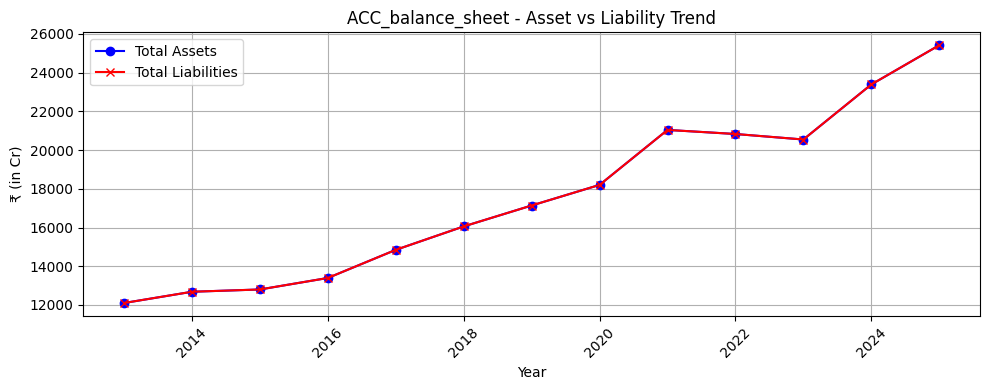

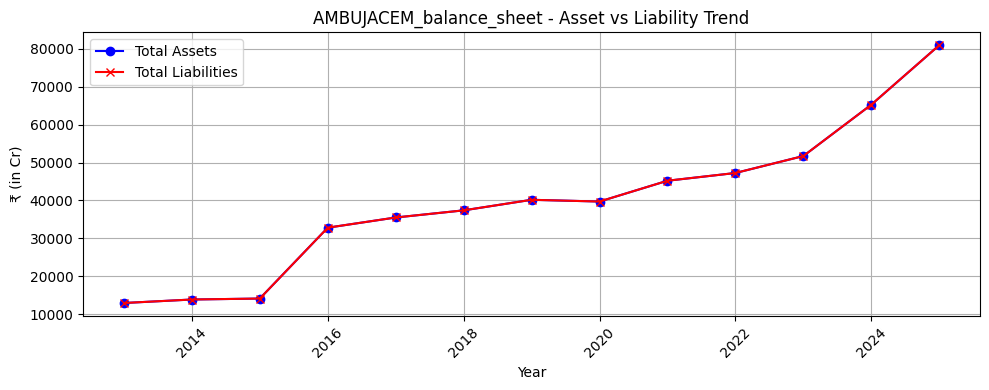

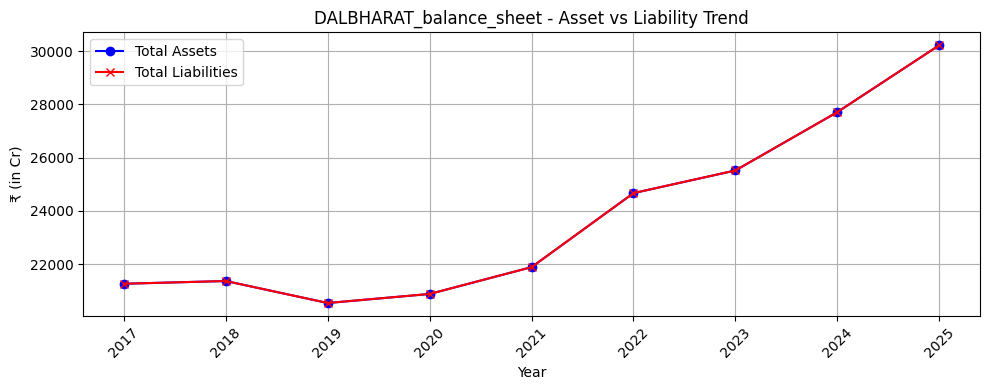

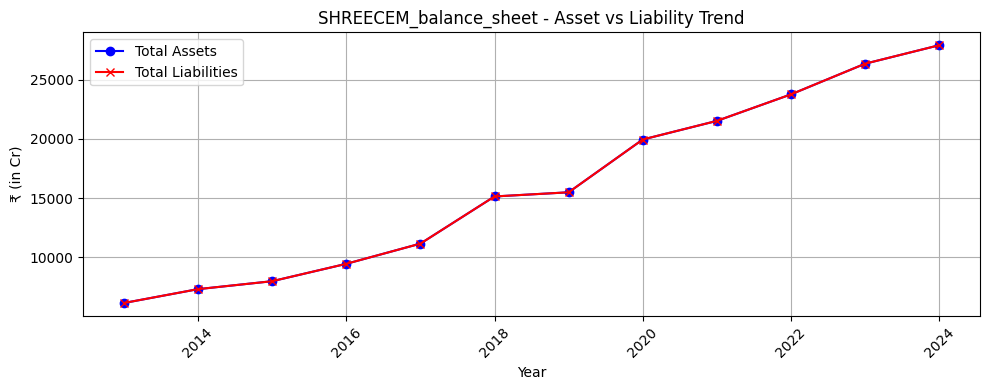

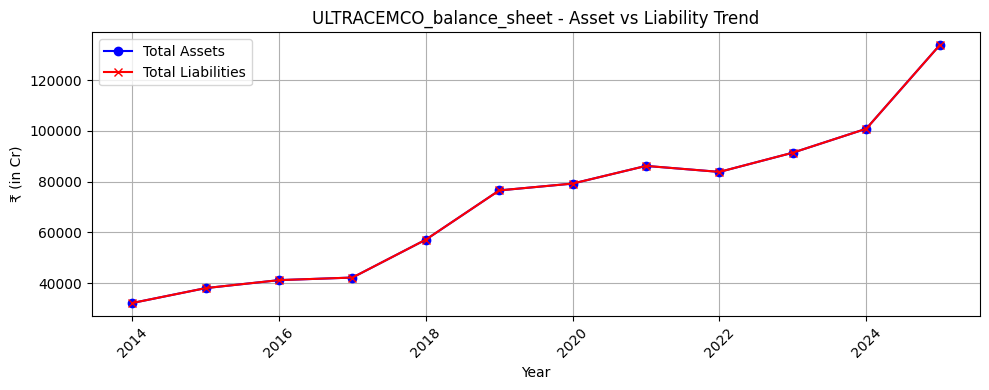

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import os

def load_and_filter_data(file_path):
    """Load Excel and filter for Total Assets and Liabilities only."""
    df = pd.read_excel(file_path)
    df = df[df['Financial_Metric'].isin(['Total Assets', 'Total Liabilities'])].copy()
    df = df[~df['Company'].str.contains('Average|Median', case=False, na=False)]
    return df

def interpolate_polynomial(df, degree=2):
    """Apply polynomial interpolation row-wise on numeric columns."""
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')
    data_numeric = df[year_cols].transpose()
    data_numeric.index = list(map(int, data_numeric.index))
    interpolated = data_numeric.interpolate(method='polynomial', order=degree).transpose()
    df[year_cols] = interpolated
    return df, year_cols

def plot_asset_liability_trend(df, year_cols, companies_to_plot=None, show=True, save_dir=None):
    """Plot asset vs liability trend for each company."""
    unique_companies = df['Company'].unique()
    for company in unique_companies:
        if companies_to_plot and company not in companies_to_plot:
            continue

        company_data = df[df['Company'] == company]
        if company_data.shape[0] < 2:
            continue

        assets = company_data[company_data['Financial_Metric'] == 'Total Assets'][year_cols].values.flatten()
        liabilities = company_data[company_data['Financial_Metric'] == 'Total Liabilities'][year_cols].values.flatten()

        plt.figure(figsize=(10, 4))
        plt.plot(year_cols, assets, marker='o', label='Total Assets', color='blue')
        plt.plot(year_cols, liabilities, marker='x', label='Total Liabilities', color='red')
        plt.title(f"{company.replace('_Balance_Sheet', '')} - Asset vs Liability Trend")
        plt.xlabel("Year")
        plt.ylabel("₹ (in Cr)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{company}_Trend.png"))
        if show:
            plt.show()
        else:
            plt.close()


file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx"
df = load_and_filter_data(file_path)
df, year_cols = interpolate_polynomial(df)
plot_asset_liability_trend(df, year_cols, companies_to_plot=None, show=True, save_dir=None)


Compare current vs. non-current assets/liabilities.


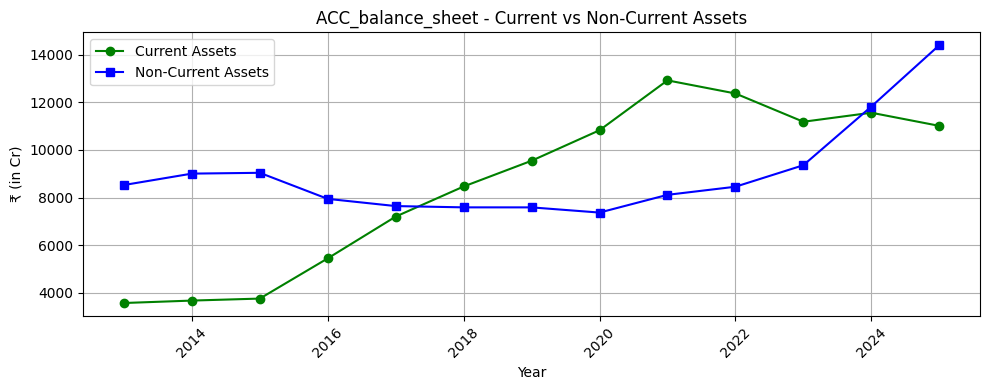

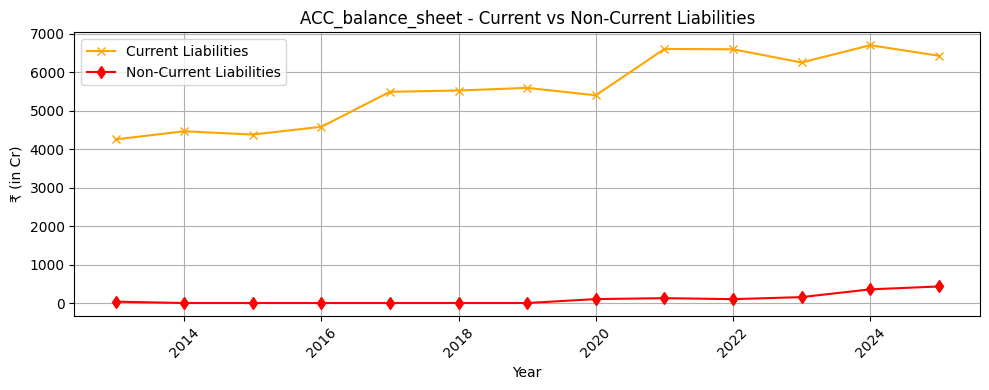

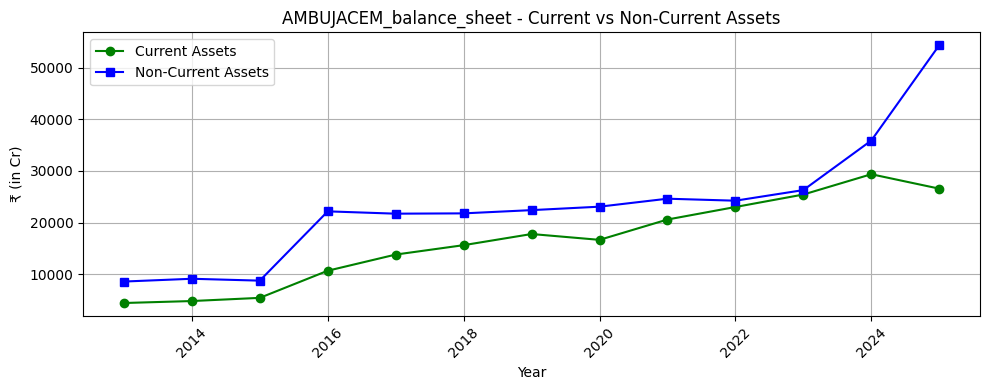

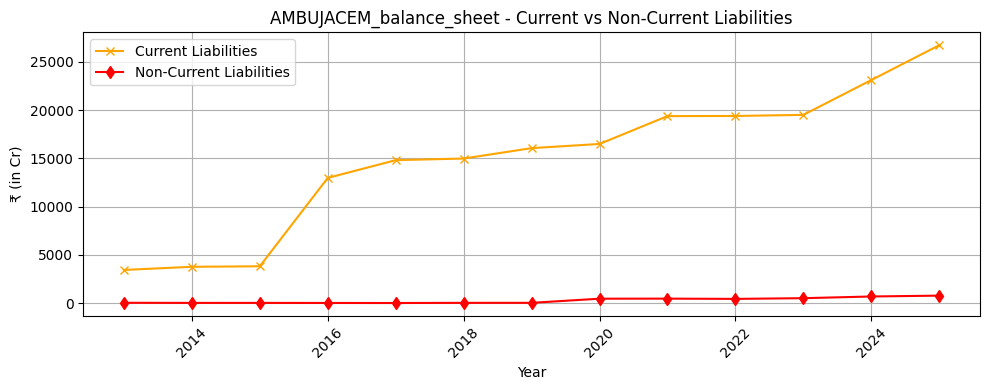

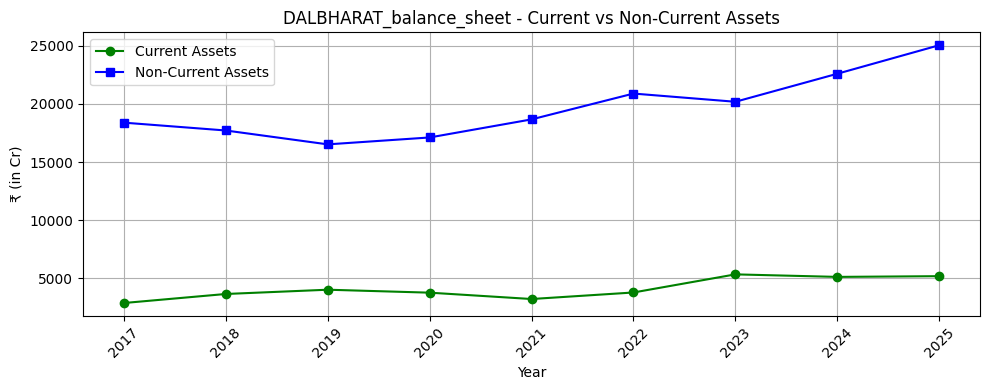

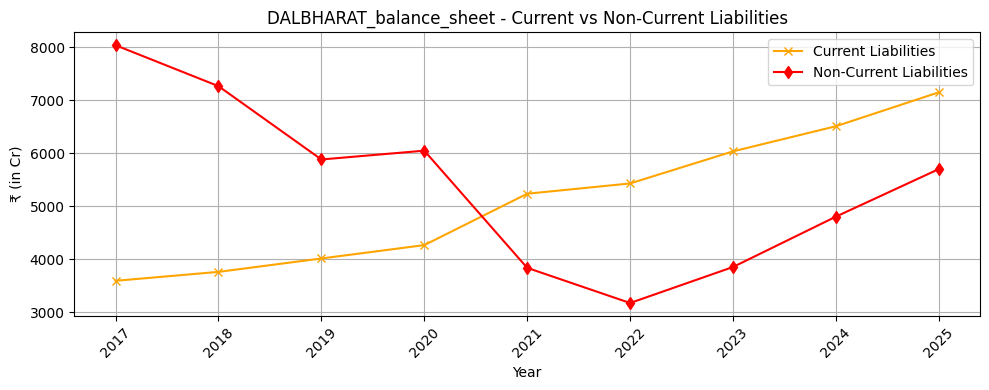

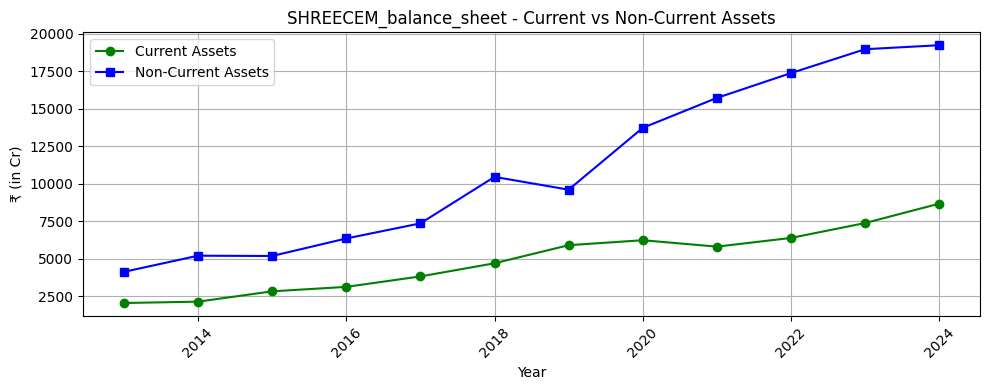

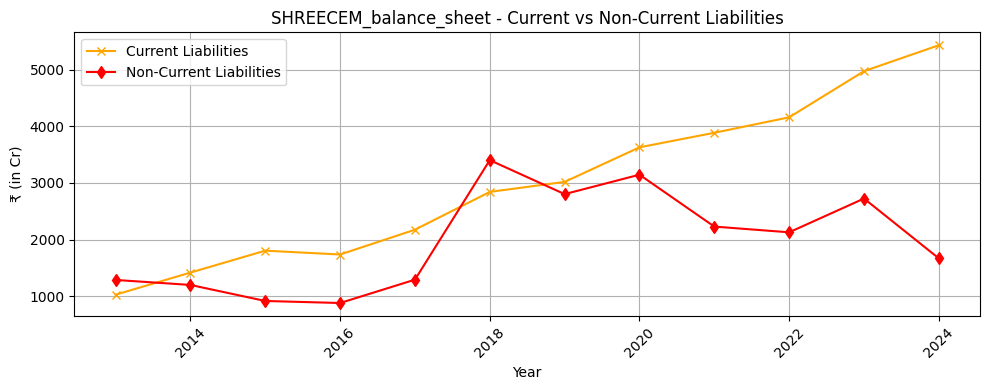

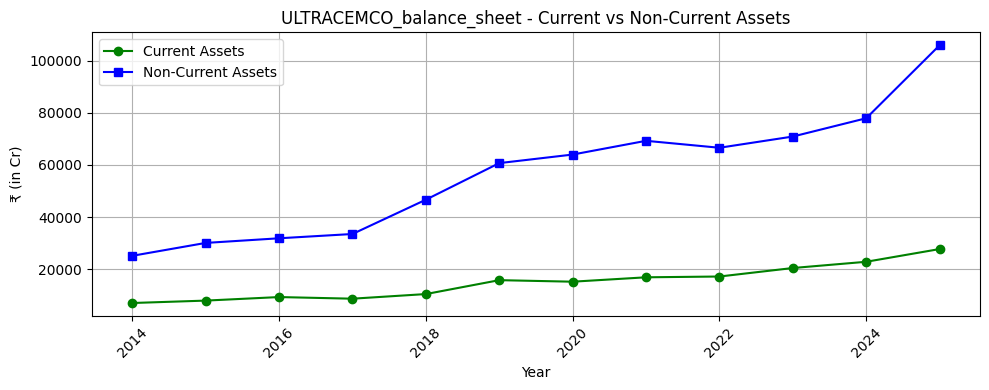

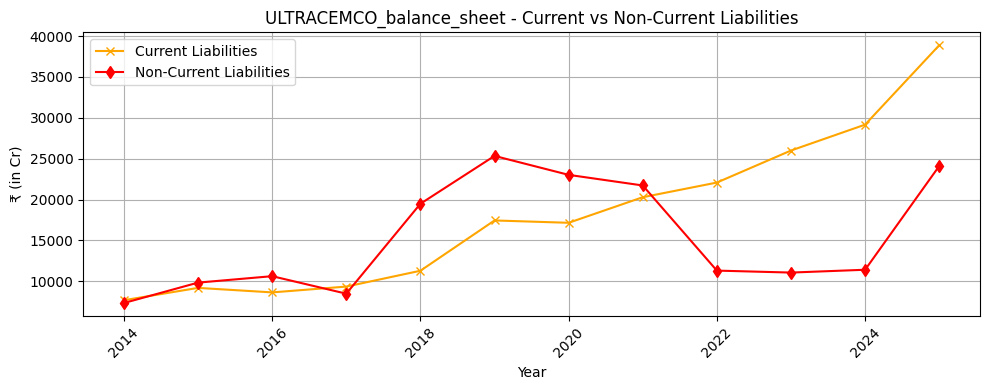

In [2]:

# ----------------------🔧 Configuration Functions ----------------------

def load_and_prepare_data(file_path, required_metrics):
    """Load Excel file and filter for relevant metrics and valid companies."""
    df = pd.read_excel(file_path)
    df = df[df['Financial_Metric'].isin(required_metrics)].copy()
    df = df[~df['Company'].str.contains('Average|Median', case=False, na=False)]
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')
    return df, year_cols

def interpolate_series(arr, year_cols):
    """Polynomial interpolation helper."""
    s = pd.Series(arr, index=list(map(int, year_cols)))
    return s.interpolate(method='polynomial', order=2).values

# ----------------------📊 Visualization Function ----------------------

def plot_current_vs_noncurrent(df, year_cols, companies=None, save_dir=None, show=True):
    """Plot current vs non-current assets and liabilities for selected companies."""
    unique_companies = df['Company'].unique()
    
    for company in unique_companies:
        if companies and company not in companies:
            continue

        company_data = df[df['Company'] == company]

        # Extract metrics
        def get_metric(metric_name):
            values = company_data[company_data['Financial_Metric'] == metric_name][year_cols].values
            return values.flatten() if len(values) > 0 else [0]*len(year_cols)

        other_assets = get_metric('Other Assets')
        fixed_assets = get_metric('Fixed Assets')
        cwip = get_metric('CWIP')
        investments = get_metric('Investments')
        other_liabilities = get_metric('Other Liabilities')
        borrowings = get_metric('Borrowings')

        # Interpolated aggregates
        current_assets = interpolate_series(other_assets, year_cols)
        non_current_assets = interpolate_series(fixed_assets + cwip + investments, year_cols)
        current_liabilities = interpolate_series(other_liabilities, year_cols)
        non_current_liabilities = interpolate_series(borrowings, year_cols)

        # Plot Assets
        plt.figure(figsize=(10, 4))
        plt.plot(year_cols, current_assets, marker='o', label='Current Assets', color='green')
        plt.plot(year_cols, non_current_assets, marker='s', label='Non-Current Assets', color='blue')
        plt.title(f"{company.replace('_Balance_Sheet', '')} - Current vs Non-Current Assets")
        plt.xlabel("Year")
        plt.ylabel("₹ (in Cr)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{company}_Assets.png"))
        if show:
            plt.show()
        else:
            plt.close()

        # Plot Liabilities
        plt.figure(figsize=(10, 4))
        plt.plot(year_cols, current_liabilities, marker='x', label='Current Liabilities', color='orange')
        plt.plot(year_cols, non_current_liabilities, marker='d', label='Non-Current Liabilities', color='red')
        plt.title(f"{company.replace('_Balance_Sheet', '')} - Current vs Non-Current Liabilities")
        plt.xlabel("Year")
        plt.ylabel("₹ (in Cr)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, f"{company}_Liabilities.png"))
        if show:
            plt.show()
        else:
            plt.close()

# ----------------------🚀 Usage Example ----------------------

# Define required metrics
required_metrics = ['Other Assets', 'Fixed Assets', 'CWIP', 'Investments', 'Other Liabilities', 'Borrowings']

# Set file path
file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx"

# Load and prepare
df, year_cols = load_and_prepare_data(file_path, required_metrics)

# Plot for all or selected companies (pass list)
plot_current_vs_noncurrent(df, year_cols, companies=None, save_dir=None, show=True)


# 2. Equity and Debt Analysis


Track share capital and reserves.





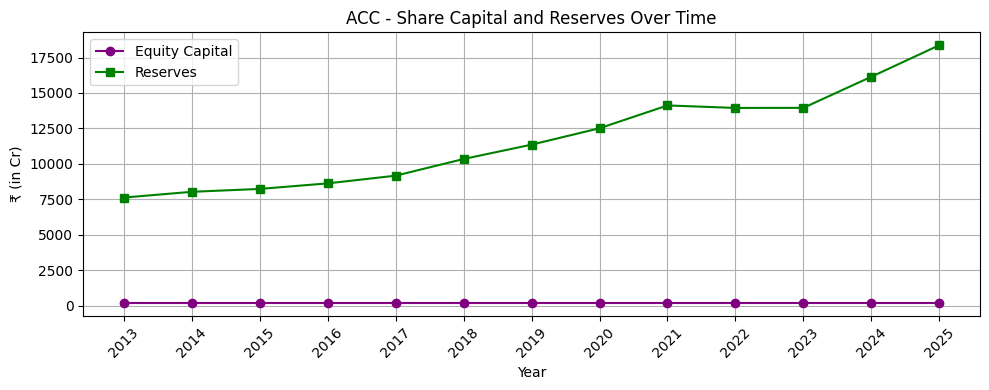

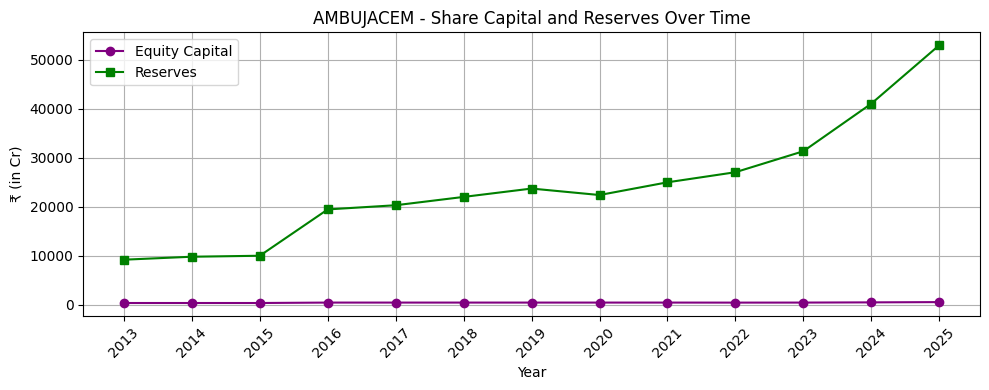

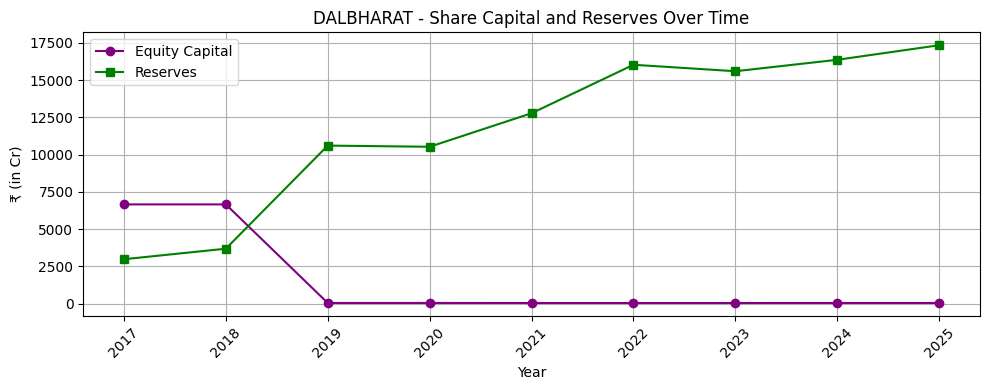

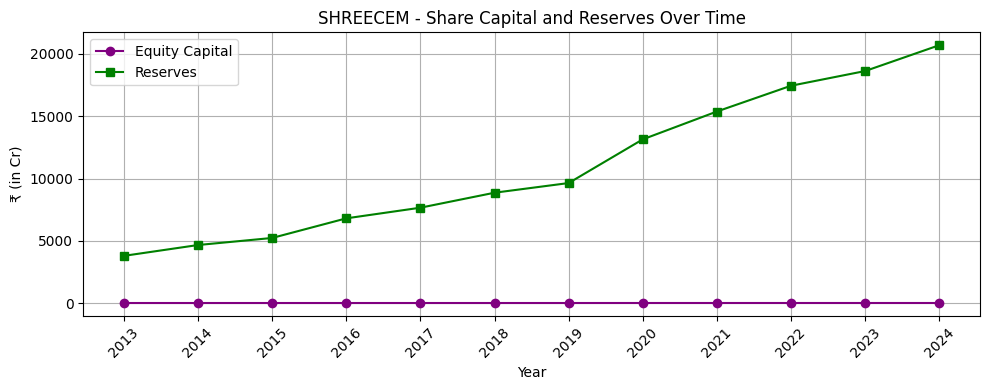

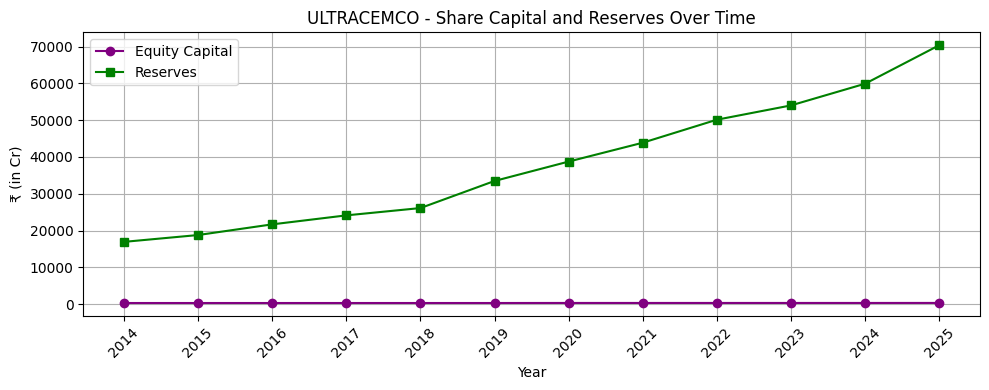

In [3]:


# ----------------------🔧 Function Definitions ----------------------

def load_and_filter_equity_reserves(file_path):
    """Load file and filter for Equity Capital and Reserves."""
    df = pd.read_excel(file_path)
    df = df[df['Financial_Metric'].isin(['Equity Capital', 'Reserves'])].copy()
    df = df[~df['Company'].str.contains('Average|Median', case=False, na=False)]
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')
    return df, year_cols

def interpolate_polynomial_rows(df, year_cols, order=2):
    """Apply polynomial interpolation row-wise."""
    data = df[year_cols].transpose()
    data.index = list(map(int, data.index))
    interpolated = data.interpolate(method='polynomial', order=order).transpose()
    df[year_cols] = interpolated
    return df

def plot_equity_reserves(df, year_cols, companies=None, save_dir=None, show=True):
    """Plot Equity Capital and Reserves over time for selected companies."""
    unique_companies = df['Company'].unique()
    for company in unique_companies:
        if companies and company not in companies:
            continue

        company_data = df[df['Company'] == company]
        if company_data.shape[0] < 2:
            continue

        equity = company_data[company_data['Financial_Metric'] == 'Equity Capital'][year_cols].values.flatten()
        reserves = company_data[company_data['Financial_Metric'] == 'Reserves'][year_cols].values.flatten()

        plt.figure(figsize=(10, 4))
        plt.plot(year_cols, equity, marker='o', label='Equity Capital', color='purple')
        plt.plot(year_cols, reserves, marker='s', label='Reserves', color='green')
        plt.title(f"{company.replace('_Balance_Sheet', '')} - Share Capital and Reserves Over Time")
        plt.xlabel("Year")
        plt.ylabel("₹ (in Cr)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"{company}_Equity_Reserves.png"))
        if show:
            plt.show()
        else:
            plt.close()

# ----------------------🚀 Usage Example ----------------------

file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\processed\Combined_Balance_With_Average_Median_Yearwise.xlsx"

# Load and prepare
df_equity, year_cols = load_and_filter_equity_reserves(file_path)

# Interpolate
df_equity = interpolate_polynomial_rows(df_equity, year_cols, order=2)

# Plot for all companies or specify a list: companies=["TCS", "INFY"]
plot_equity_reserves(df_equity, year_cols, companies=None, save_dir=None, show=True)


 Calculate Change and Growth Rate in Share Capital and Reserves

 No change in Equity Capital: It remained the same each year, meaning the company did not issue new shares or buy back any shares during this period.

In [7]:

# Step 1: Load and filter for Equity Capital and Reserves
def load_and_prepare_equity_data(file_path):
    df = pd.read_excel(file_path)
    df = df[df['Financial_Metric'].isin(['Equity Capital', 'Reserves'])].copy()
    df = df[~df['Company'].str.contains('Average|Median', case=False, na=False)]

    year_cols = [col for col in df.columns if str(col).isdigit()]
    df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')
    
    # Interpolate missing values
    data_numeric = df[year_cols].transpose()
    data_numeric.index = list(map(int, data_numeric.index))
    interpolated = data_numeric.interpolate(method='polynomial', order=2).transpose()
    df[year_cols] = interpolated
    
    return df, year_cols

def compute_equity_reserve_growth(df, year_cols, companies=None):
    """Compute year-on-year changes and growth (%) in Equity Capital and Reserves."""
    results = []

    for company in df['Company'].unique():
        if companies and company not in companies:
            continue

        company_data = df[df['Company'] == company]
        if company_data.shape[0] < 2:
            continue

        # Extract values
        equity = company_data[company_data['Financial_Metric'] == 'Equity Capital'][year_cols].values.flatten()
        reserves = company_data[company_data['Financial_Metric'] == 'Reserves'][year_cols].values.flatten()

        for i in range(1, len(year_cols)):
            year = int(year_cols[i])
            prev_year = int(year_cols[i - 1])

            equity_change = equity[i] - equity[i - 1]
            equity_growth = ((equity[i] - equity[i - 1]) / abs(equity[i - 1]) * 100) if equity[i - 1] != 0 else None

            reserves_change = reserves[i] - reserves[i - 1]
            reserves_growth = ((reserves[i] - reserves[i - 1]) / abs(reserves[i - 1]) * 100) if reserves[i - 1] != 0 else None

            results.append({
                "Company": company.replace('_Balance_Sheet', ''),
                "Year": f"{prev_year}-{year}",
                "Equity_Change": equity_change,
                "Equity_Growth_%": equity_growth,
                "Reserves_Change": reserves_change,
                "Reserves_Growth_%": reserves_growth
            })

    growth_df = pd.DataFrame(results)
    return growth_df

# ----------------------🚀 Usage Example ----------------------

# Assuming df_equity_debt and year_cols are already defined from previous steps:
#   df_equity_debt = interpolate_polynomial_rows(df_equity_debt, year_cols)

# Load and prepare data
file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx"
df_equity_debt, year_cols = load_and_prepare_equity_data(file_path)

# Compute equity & reserve growth
growth_df = compute_equity_reserve_growth(df_equity_debt, year_cols, companies=None)

# Display result
pd.set_option('display.float_format', '{:.2f}'.format)
print(growth_df.head())

# Optional: Export to Excel
# growth_df.to_excel("Equity_Reserves_Growth_Report.xlsx", index=False)


             Company       Year  Equity_Change  Equity_Growth_%  \
0  ACC_balance_sheet  2013-2014           0.00             0.00   
1  ACC_balance_sheet  2014-2015           0.00             0.00   
2  ACC_balance_sheet  2015-2016           0.00             0.00   
3  ACC_balance_sheet  2016-2017           0.00             0.00   
4  ACC_balance_sheet  2017-2018           0.00             0.00   

   Reserves_Change  Reserves_Growth_%  
0           405.00               5.31  
1           203.00               2.53  
2           392.00               4.76  
3           543.00               6.30  
4          1176.00              12.83  


Analyze long-term vs. short-term borrowings.

In financial data:

Long-term borrowings (non-current liabilities): Debts due after 12 months, such as bonds, term loans.

Short-term borrowings (current liabilities): Debts due within 12 months, often included under "Other Liabilities" or explicitly labeled.

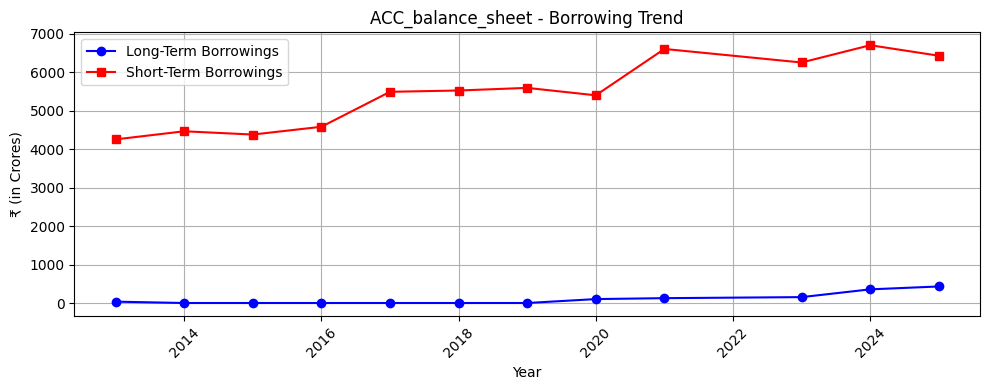

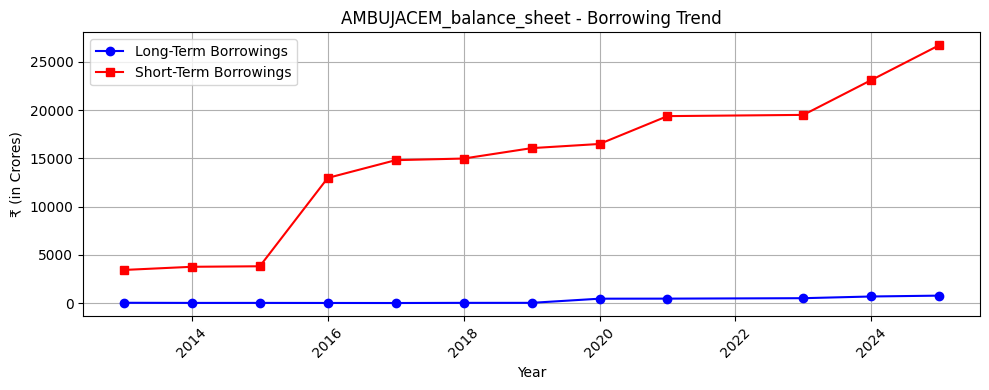

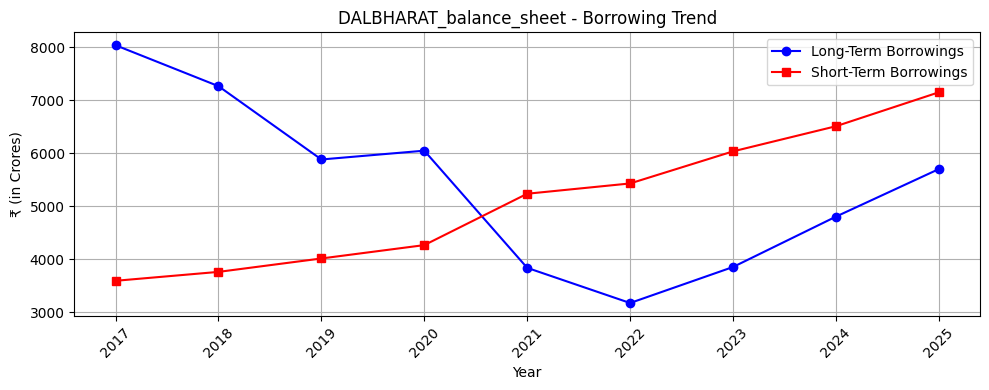

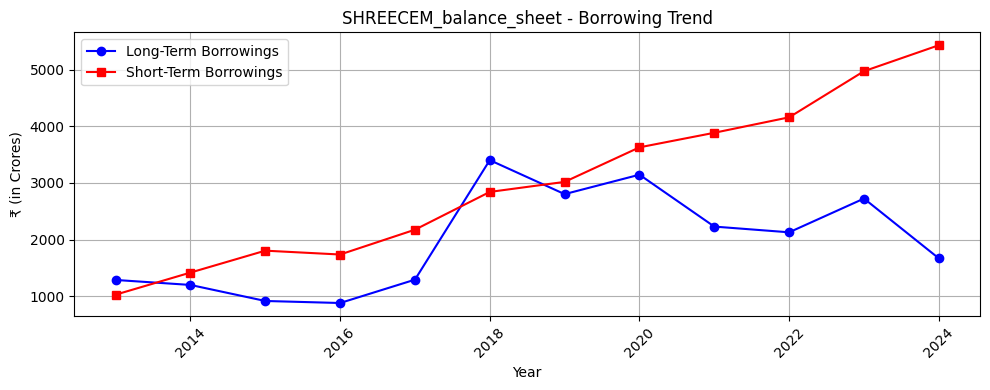

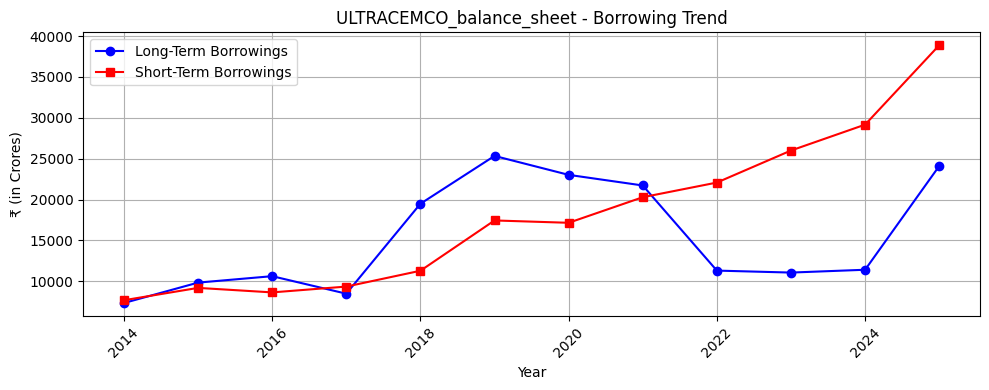

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ----------------------🔧 Helper Functions ----------------------

def process_borrowing_data(df, year_cols, companies=None):
    """Processes borrowing data and calculates composition ratios."""

    # Filter relevant financial metrics
    borrow_df = df[df['Financial_Metric'].isin(['Borrowings', 'Other Liabilities'])].copy()
    borrow_df = borrow_df[~borrow_df['Company'].str.contains('Average|Median', case=False, na=False)]

    if companies:
        borrow_df = borrow_df[borrow_df['Company'].isin(companies)]

    borrow_df[year_cols] = borrow_df[year_cols].apply(pd.to_numeric, errors='coerce')

    # Reshape to long format
    melted = borrow_df.melt(
        id_vars=['Company', 'Financial_Metric'],
        value_vars=year_cols,
        var_name='Year',
        value_name='Value'
    )
    melted['Year'] = melted['Year'].astype(int)

    # Pivot to wide format
    pivot = melted.pivot_table(
        index=['Company', 'Year'],
        columns='Financial_Metric',
        values='Value'
    ).reset_index()

    # Rename columns
    pivot.rename(columns={
        'Borrowings': 'Long_Term_Borrowings',
        'Other Liabilities': 'Short_Term_Borrowings'
    }, inplace=True)

    # Calculate composition ratios
    pivot['Total_Borrowings'] = pivot['Long_Term_Borrowings'] + pivot['Short_Term_Borrowings']
    pivot['LT_Borrowing_%'] = (pivot['Long_Term_Borrowings'] / pivot['Total_Borrowings']) * 100
    pivot['ST_Borrowing_%'] = (pivot['Short_Term_Borrowings'] / pivot['Total_Borrowings']) * 100

    # Sort for clarity
    pivot.sort_values(['Company', 'Year'], inplace=True)

    return pivot

def plot_borrowing_trend(pivot_df, companies=None, show=True, save_dir=None):
    """Plots long-term vs short-term borrowing trends for each company."""
    unique_companies = pivot_df['Company'].unique()

    for company in unique_companies:
        if companies and company not in companies:
            continue

        company_df = pivot_df[pivot_df['Company'] == company]

        plt.figure(figsize=(10, 4))
        plt.plot(company_df['Year'], company_df['Long_Term_Borrowings'], marker='o', label='Long-Term Borrowings', color='blue')
        plt.plot(company_df['Year'], company_df['Short_Term_Borrowings'], marker='s', label='Short-Term Borrowings', color='red')
        plt.title(f"{company.replace('_Balance_Sheet', '')} - Borrowing Trend")
        plt.xlabel('Year')
        plt.ylabel('₹ (in Crores)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            file_name = os.path.join(save_dir, f"{company}_Borrowing_Trend.png")
            plt.savefig(file_name)

        if show:
            plt.show()
        else:
            plt.close()

# ----------------------🚀 Example Usage ----------------------

# Step 1: Load full dataset
file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx"
df = pd.read_excel(file_path)

# Step 2: Detect year columns
year_cols = [col for col in df.columns if str(col).isdigit()]

# Step 3: Process borrowing data and calculate ratios
borrowings_df = process_borrowing_data(df, year_cols, companies=None)

# Step 4: Plot borrowing trends
plot_borrowing_trend(borrowings_df, companies=None, show=True, save_dir=None)

# Optional: Save the processed data
# borrowings_df.to_excel("Borrowing_Trends_Composition.xlsx", index=False)


# 3. Leverage Ratios


Debt/Equity Ratio = Total Debt / Shareholder’s Equity.

Debt/Equity Ratio evaluates a company's financial leverage by comparing its total debt to shareholders' equity:


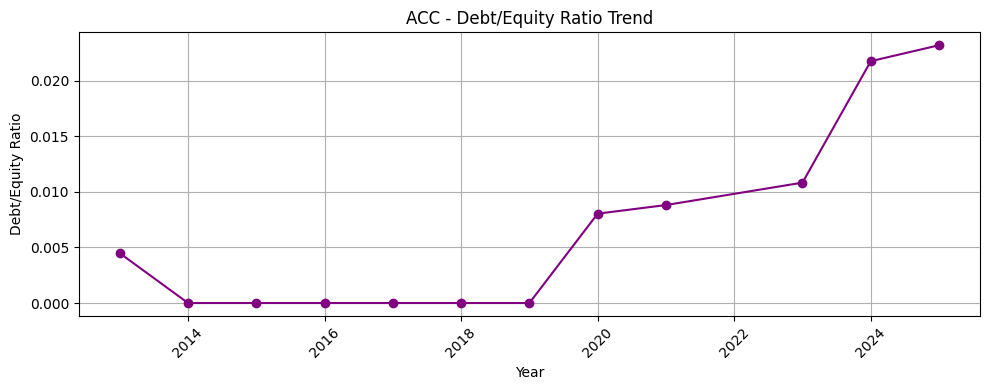

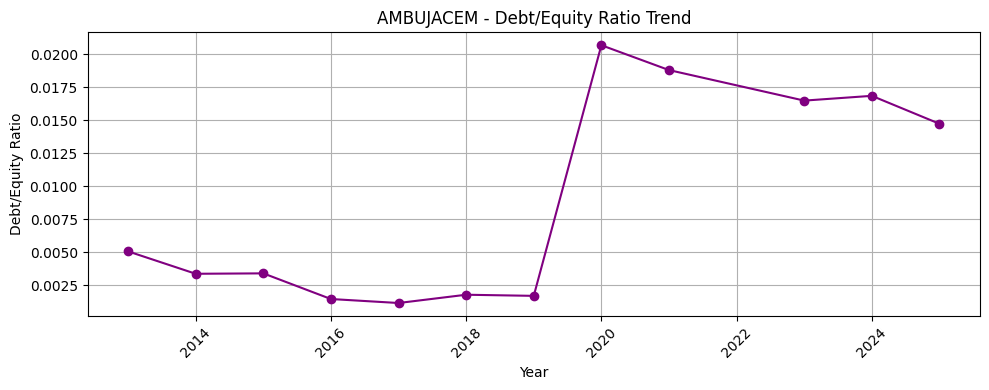

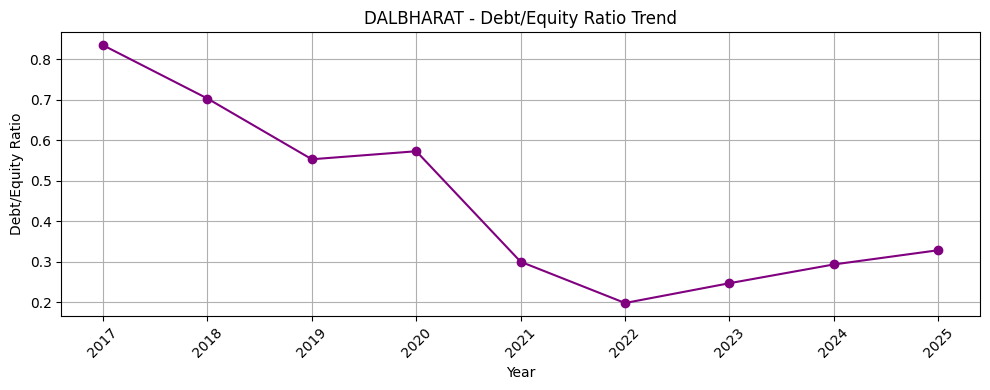

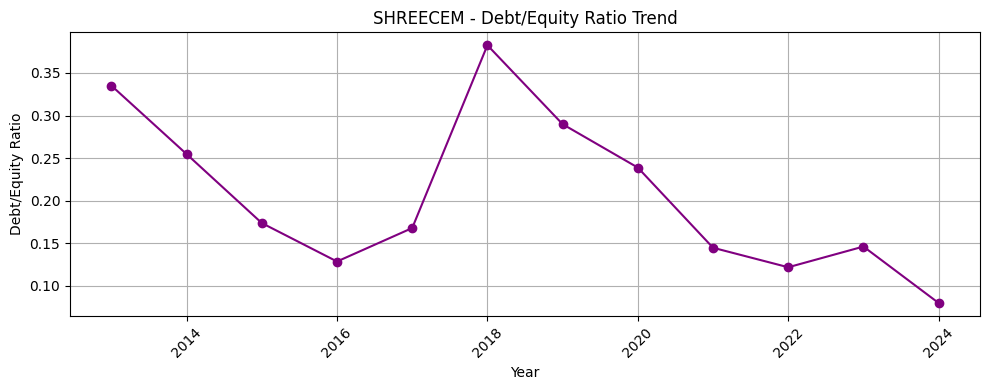

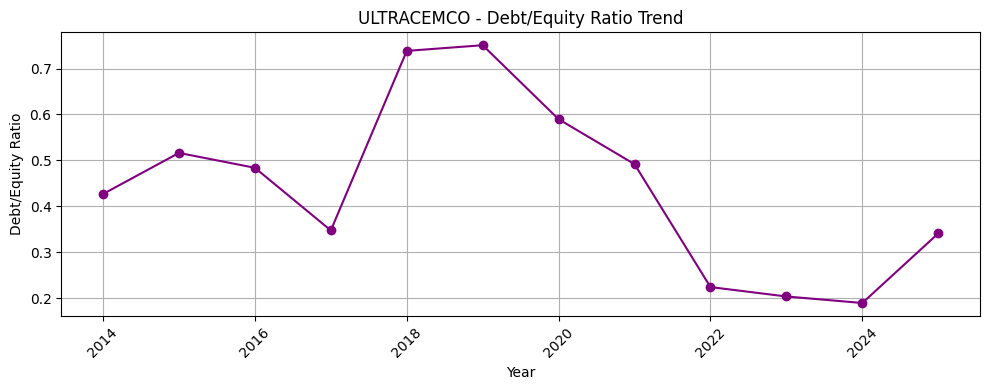

In [10]:


# ----------------------🔧 Function Definitions ----------------------

def process_debt_equity_data(df, year_cols, companies=None):
    """
    Process balance sheet data to compute Debt-Equity Ratio for each company-year.

    Returns:
    - A pivoted DataFrame with Total_Debt, Shareholders_Equity, and Debt_Equity_Ratio
    """
    relevant_metrics = ['Borrowings', 'Equity Capital', 'Reserves']
    df_filtered = df[df['Financial_Metric'].isin(relevant_metrics)].copy()
    df_filtered = df_filtered[~df_filtered['Company'].str.contains('Average|Median', case=False, na=False)]

    if companies:
        df_filtered = df_filtered[df_filtered['Company'].isin(companies)]

    df_filtered[year_cols] = df_filtered[year_cols].apply(pd.to_numeric, errors='coerce')

    melted = df_filtered.melt(
        id_vars=['Company', 'Financial_Metric'],
        value_vars=year_cols,
        var_name='Year',
        value_name='Value'
    )
    melted['Year'] = melted['Year'].astype(int)

    pivot_df = melted.pivot_table(
        index=['Company', 'Year'],
        columns='Financial_Metric',
        values='Value'
    ).reset_index()

    pivot_df.rename(columns={
        'Borrowings': 'Total_Debt',
        'Equity Capital': 'Equity_Capital',
        'Reserves': 'Reserves'
    }, inplace=True)

    pivot_df['Shareholders_Equity'] = pivot_df['Equity_Capital'] + pivot_df['Reserves']
    pivot_df['Debt_Equity_Ratio'] = pivot_df['Total_Debt'] / pivot_df['Shareholders_Equity']

    return pivot_df

def plot_debt_equity_trend(pivot_df, companies=None, save_dir=None, show=True):
    """
    Plot Debt/Equity Ratio trend for each company.
    """
    unique_companies = pivot_df['Company'].unique()

    for company in unique_companies:
        if companies and company not in companies:
            continue

        company_df = pivot_df[pivot_df['Company'] == company]

        plt.figure(figsize=(10, 4))
        plt.plot(company_df['Year'], company_df['Debt_Equity_Ratio'], marker='o', color='purple')
        plt.title(f"{company.replace('_Balance_Sheet', '')} - Debt/Equity Ratio Trend")
        plt.xlabel("Year")
        plt.ylabel("Debt/Equity Ratio")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            filename = os.path.join(save_dir, f"{company}_DebtEquityTrend.png")
            plt.savefig(filename)
        if show:
            plt.show()
        else:
            plt.close()

# ----------------------🚀 Example Usage ----------------------

# Step 1: Load the Excel file
file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\processed\Combined_Balance_With_Average_Median_Yearwise.xlsx"
df = pd.read_excel(file_path)

# Step 2: Detect year columns
year_cols = [col for col in df.columns if str(col).isdigit()]

# Step 3: Process for Debt-Equity computation
de_df = process_debt_equity_data(df, year_cols, companies=None)

# Step 4: Plot the Debt-Equity trend
plot_debt_equity_trend(de_df, companies=None, save_dir=None, show=True)

# Optional: Export to Excel
# de_df.to_excel("Debt_Equity_Ratios.xlsx", index=False)


Interest Coverage Ratio (if interest expense is available).




In [11]:


# ----------------------🔧 Function Definitions ----------------------

def compute_interest_coverage_ratio(pl_df, companies=None):
    """
    Computes Interest Coverage Ratio (ICR) = Operating Profit / Interest

    Parameters:
    - pl_df: Profit & Loss DataFrame (with Financial_Metric column)
    - companies: Optional list of company names to include

    Returns:
    - Cleaned DataFrame with columns: Company, Year, Operating Profit, Interest, Interest_Coverage_Ratio
    """

    # Step 1: Filter required metrics
    filtered = pl_df[pl_df['Financial_Metric'].isin(['Operating Profit', 'Interest'])].copy()

    if companies:
        filtered = filtered[filtered['Company'].isin(companies)]

    # Step 2: Detect year columns
    year_cols = [col for col in filtered.columns if any(char.isdigit() for char in str(col))]

    # Step 3: Reshape to long format
    long_df = filtered.melt(
        id_vars=['Company', 'Financial_Metric'],
        value_vars=year_cols,
        var_name='Year',
        value_name='Amount'
    )

    # Step 4: Normalize year
    long_df['Year'] = long_df['Year'].astype(str).str.extract(r'(\d{4})').astype(int)

    # Step 5: Pivot metrics as columns
    pivot_df = long_df.pivot_table(
        index=['Company', 'Year'],
        columns='Financial_Metric',
        values='Amount'
    ).reset_index()

    # Step 6: Numeric conversion
    pivot_df['Operating Profit'] = pd.to_numeric(pivot_df['Operating Profit'], errors='coerce')
    pivot_df['Interest'] = pd.to_numeric(pivot_df['Interest'], errors='coerce')

    # Step 7: Calculate ICR
    pivot_df['Interest_Coverage_Ratio'] = pivot_df['Operating Profit'] / pivot_df['Interest']
    pivot_df['Interest_Coverage_Ratio'] = pivot_df['Interest_Coverage_Ratio'].replace([float('inf'), -float('inf')], pd.NA)

    # Step 8: Final clean output
    final_df = pivot_df[['Company', 'Year', 'Operating Profit', 'Interest', 'Interest_Coverage_Ratio']]

    return final_df.dropna()

# ----------------------🚀 Example Usage ----------------------

# Step 1: Load your P&L Excel file
file_path = r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\processed\Combined_PnL_Yearwise.xlsx"
pl_df = pd.read_excel(file_path)

# Step 2: Compute ICR dynamically
icr_df = compute_interest_coverage_ratio(pl_df, companies=None)

# Step 3: Display
print(icr_df.head())

# Optional: Export to Excel
# icr_df.to_excel("Interest_Coverage_Ratio_Report.xlsx", index=False)


Financial_Metric            Company  Year  Operating Profit  Interest  \
0                 ACC_Profit_&_Loss  2013           1646.00    114.00   
1                 ACC_Profit_&_Loss  2014           1529.00     83.00   
2                 ACC_Profit_&_Loss  2015           1583.00     65.00   
3                 ACC_Profit_&_Loss  2016           1458.00     79.00   
4                 ACC_Profit_&_Loss  2017           1915.00     99.00   

Financial_Metric  Interest_Coverage_Ratio  
0                                   14.44  
1                                   18.42  
2                                   24.35  
3                                   18.46  
4                                   19.34  


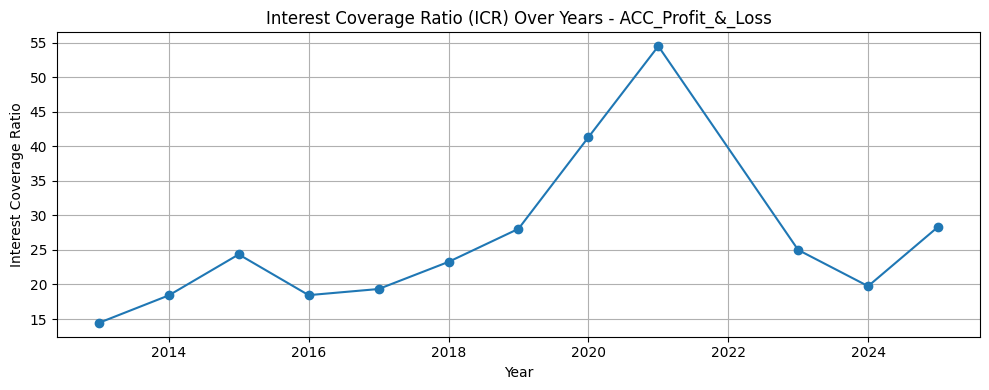

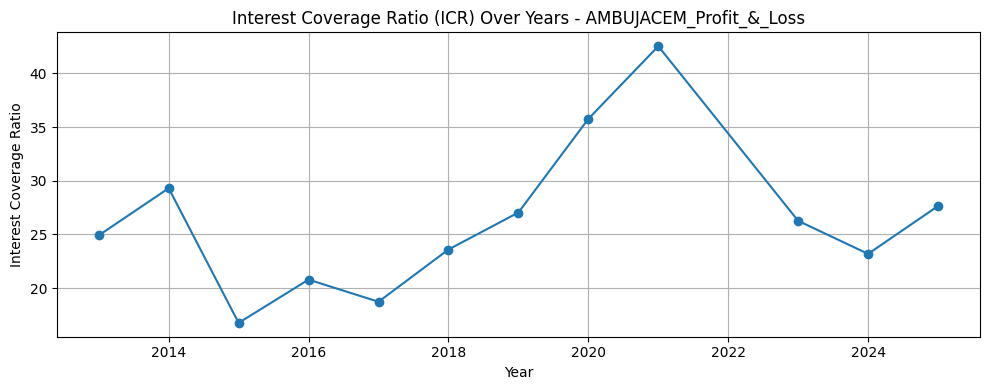

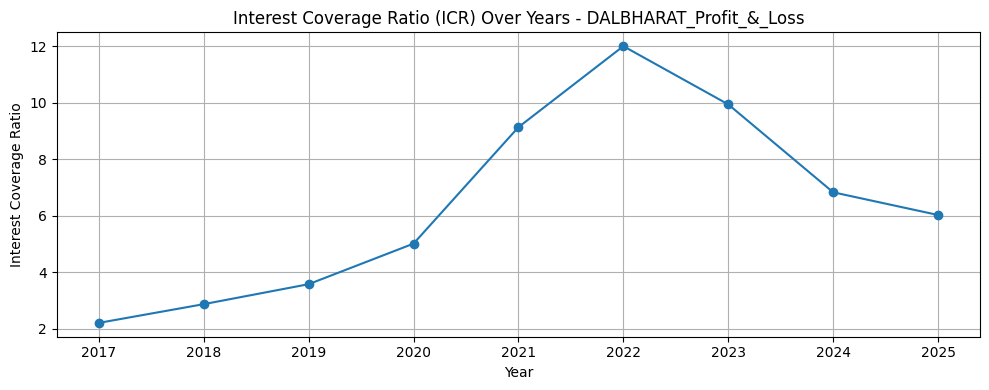

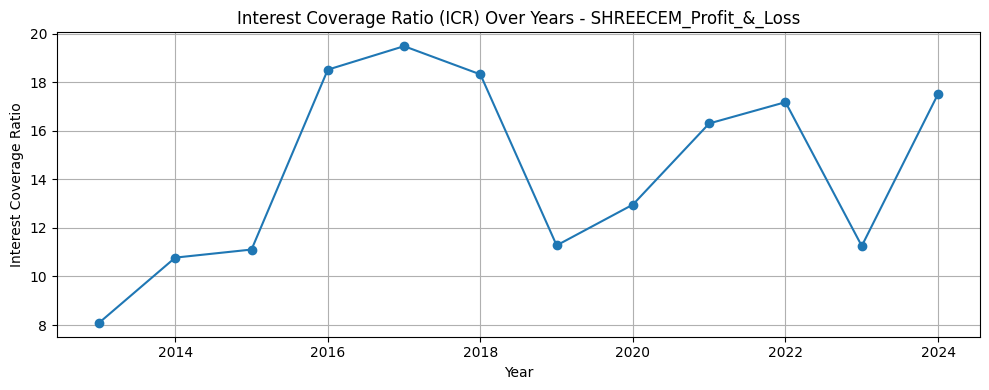

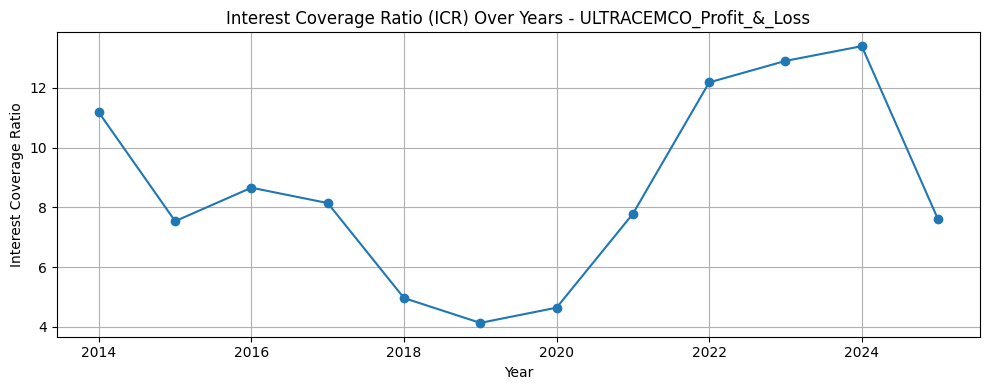

In [14]:

def plot_interest_coverage_trends(df, companies=None, save_dir=None, show=True):
    """
    Plots Interest Coverage Ratio (ICR) trends year-wise for each company.

    Parameters:
    - df: DataFrame containing 'Company', 'Year', and 'Interest_Coverage_Ratio'
    - companies: Optional list of companies to plot
    - save_dir: Optional directory to save plots (if None, plots are not saved)
    - show: Whether to show plots (if False, plots are created and closed)
    """

    # Filter out rows with missing ICR
    plot_df = df.dropna(subset=['Interest_Coverage_Ratio'])

    for company in plot_df['Company'].unique():
        if companies and company not in companies:
            continue

        company_df = plot_df[plot_df['Company'] == company]

        plt.figure(figsize=(10, 4))
        plt.plot(company_df['Year'], company_df['Interest_Coverage_Ratio'], marker='o', linestyle='-')
        plt.title(f'Interest Coverage Ratio (ICR) Over Years - {company}')
        plt.xlabel('Year')
        plt.ylabel('Interest Coverage Ratio')
        plt.grid(True)
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            filename = os.path.join(save_dir, f"{company}_ICR_Trend.png")
            plt.savefig(filename)

        if show:
            plt.show()
        else:
            plt.close()
            
# Plot all companies interactively
plot_interest_coverage_trends(icr_df)



# 4. Efficiency Metrics


Asset Turnover Ratio = Revenue / Total Assets.







In [20]:
import pandas as pd

def compute_asset_turnover_ratio(bs_df, pl_df, companies=None):
    
    # 🔹 Step 1: Filter out Average/Median rows and add Company_Code
    bs_df = bs_df[~bs_df['Company'].str.contains('Average|Median', case=False, na=False)].copy()
    pl_df = pl_df[~pl_df['Company'].str.contains('Average|Median', case=False, na=False)].copy()

    bs_df['Company_Code'] = bs_df['Company'].str[:3].str.upper()
    pl_df['Company_Code'] = pl_df['Company'].str[:3].str.upper()

    # 🔹 Step 2: Filter required metrics
    bs_filtered = bs_df[bs_df['Financial_Metric'].str.strip().str.lower() == 'total assets'].copy()
    pl_filtered = pl_df[pl_df['Financial_Metric'].str.strip().str.lower() == 'sales'].copy()

    # 🔹 Optional: Filter selected companies
    if companies:
        bs_filtered = bs_filtered[bs_filtered['Company_Code'].isin(companies)].copy()
        pl_filtered = pl_filtered[pl_filtered['Company_Code'].isin(companies)].copy()

    # 🔹 Step 3: Standardize year columns to strings
    bs_filtered.columns = [str(col) if isinstance(col, int) else col for col in bs_filtered.columns]
    pl_filtered.columns = [str(col) if isinstance(col, int) else col for col in pl_filtered.columns]

    # 🔹 Step 4: Detect matching year columns
    bs_years = [col for col in bs_filtered.columns if col.isdigit()]
    pl_years = [col for col in pl_filtered.columns if col.isdigit()]
    year_cols = sorted(set(bs_years).intersection(pl_years))

    if not year_cols:
        raise ValueError("❌ No common numeric year columns found in both Balance Sheet and P&L data.")

    # 🔹 Step 5: Melt to long format
    bs_long = bs_filtered.melt(id_vars=['Company_Code'], value_vars=year_cols,
                               var_name='Year', value_name='Total_Assets')
    pl_long = pl_filtered.melt(id_vars=['Company_Code'], value_vars=year_cols,
                               var_name='Year', value_name='Revenue')

    # 🔹 Step 6: Convert columns to correct types
    bs_long['Year'] = bs_long['Year'].astype(int)
    pl_long['Year'] = pl_long['Year'].astype(int)
    bs_long['Total_Assets'] = pd.to_numeric(bs_long['Total_Assets'], errors='coerce')
    pl_long['Revenue'] = pd.to_numeric(pl_long['Revenue'], errors='coerce')

    # 🔹 Step 7: Merge and compute Asset Turnover Ratio
    merged_df = pd.merge(pl_long, bs_long, on=['Company_Code', 'Year'], how='inner')
    merged_df['Asset_Turnover_Ratio'] = merged_df['Revenue'] / merged_df['Total_Assets']
    merged_df['Asset_Turnover_Ratio'] = merged_df['Asset_Turnover_Ratio'].replace([float('inf'), -float('inf')], pd.NA)

    return merged_df.dropna(subset=['Asset_Turnover_Ratio']).reset_index(drop=True)

# 🔹 Load DataFrames
bs_df = pd.read_excel(r"C:\Users\ASUS\Desktop\College_Last_sem_pro\College\Combined_Balance_Sheet_Averaged.xlsx")
pl_df = pd.read_excel(r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\processed\Combined_PnL_Yearwise.xlsx")

# 🔹 Compute ATR
atr_df = compute_asset_turnover_ratio(bs_df, pl_df)

# 🔹 Display sample output
pd.set_option('display.float_format', '{:.2f}'.format)
print(atr_df.head())


  Company_Code  Year  Revenue  Total_Assets  Asset_Turnover_Ratio
0          AMB  2013  9161.00      12956.00                  0.71
1          ACC  2013 11062.00      12101.00                  0.91
2          SHR  2013  5418.00       6160.00                  0.88
3          AMB  2014  9955.00      13878.00                  0.72
4          ULT  2014 20730.00      32185.00                  0.64


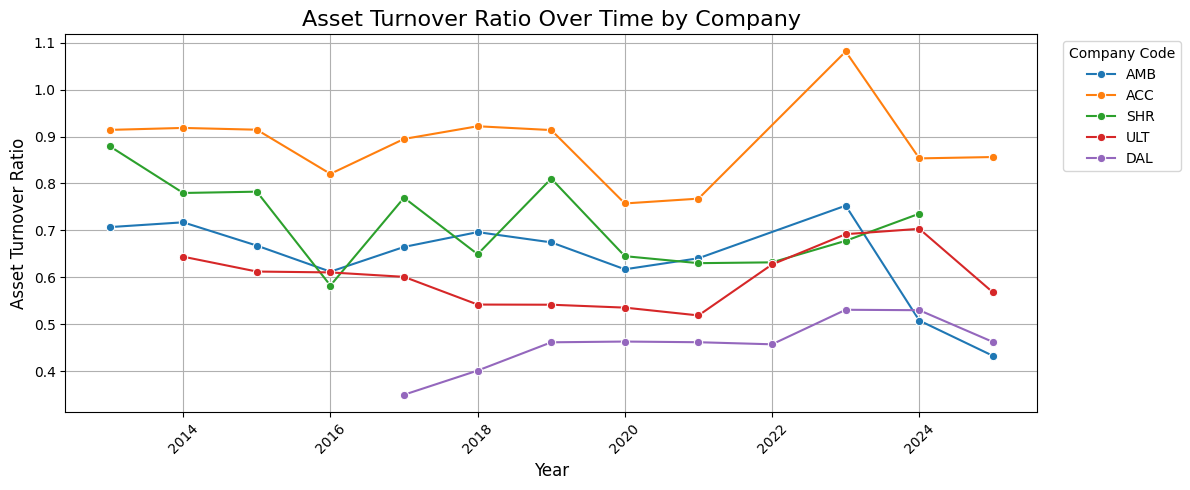

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_asset_turnover_ratio(df, companies=None, title="Asset Turnover Ratio Over Time by Company"):
   
    # Filter out rows with missing values
    plot_df = df.dropna(subset=['Asset_Turnover_Ratio']).copy()

    # Filter specific companies if provided
    if companies:
        plot_df = plot_df[plot_df['Company_Code'].isin(companies)]

    if plot_df.empty:
        print("❌ No data available to plot after filtering.")
        return

    # Plotting
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=plot_df, x='Year', y='Asset_Turnover_Ratio',
                 hue='Company_Code', marker='o', palette='tab10')

    plt.title(title, fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Asset Turnover Ratio", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Company Code", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
# Example: Plot all companies
plot_asset_turnover_ratio(atr_df)


Capital Employed = Total Assets - Current Liabilities.

In [27]:
import pandas as pd

def compute_capital_employed_from_balance_sheet(bs_df, companies=None):

    # 🔹 Step 1: Clean data
    bs_df = bs_df[~bs_df['Company'].str.contains('Average|Median', case=False, na=False)].copy()
    bs_df['Company_Code'] = bs_df['Company'].str[:3].str.upper()

    # 🔹 Step 2: Filter required metrics
    required_metrics = ['Total Assets', 'Total Liabilities', 'Borrowings', 'Other Liabilities']
    bs_filtered = bs_df[bs_df['Financial_Metric'].isin(required_metrics)].copy()

    # 🔹 Optional filter for companies
    if companies:
        bs_filtered = bs_filtered[bs_filtered['Company_Code'].isin(companies)]

    # 🔹 Step 3: Detect year columns
    year_cols = [col for col in bs_filtered.columns if str(col).isdigit()]
    if not year_cols:
        raise ValueError("❌ No valid year columns found in the data.")

    # 🔹 Step 4: Melt to long format
    bs_long = bs_filtered.melt(id_vars=['Company_Code', 'Financial_Metric'],
                               value_vars=year_cols,
                               var_name='Year',
                               value_name='Amount')
    bs_long['Year'] = bs_long['Year'].astype(int)
    bs_long['Amount'] = pd.to_numeric(bs_long['Amount'], errors='coerce')

    # 🔹 Step 5: Pivot metrics into columns
    pivot_df = bs_long.pivot_table(index=['Company_Code', 'Year'],
                                   columns='Financial_Metric',
                                   values='Amount').reset_index()

    # 🔹 Step 6: Calculate derived metrics
    pivot_df['Current_Liabilities'] = (
        pivot_df['Total Liabilities'] -
        pivot_df.get('Borrowings', 0) -
        pivot_df.get('Other Liabilities', 0)
    )

    pivot_df['Capital_Employed'] = pivot_df['Total Assets'] - pivot_df['Current_Liabilities']

    # 🔹 Final Output
    return pivot_df[['Company_Code', 'Year', 'Total Assets', 'Current_Liabilities', 'Capital_Employed']].dropna()

# Load the Balance Sheet data
bs_df = pd.read_excel(r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\processed\Combined_Balance_With_Average_Median_Yearwise.xlsx")

# Compute capital employed for all companies
capital_df = compute_capital_employed_from_balance_sheet(bs_df)

# OR only for selected companies
# capital_df = compute_capital_employed_from_balance_sheet(bs_df, companies=['TCS', 'INF', 'HDF'])

# Display output
pd.set_option('display.float_format', '{:.2f}'.format)
print(capital_df.head())



Financial_Metric Company_Code  Year  Total Assets  Current_Liabilities  \
0                         ACC  2013      12101.00              7813.00   
1                         ACC  2014      12682.00              8218.00   
2                         ACC  2015      12800.00              8421.00   
3                         ACC  2016      13394.00              8813.00   
4                         ACC  2017      14846.00              9356.00   

Financial_Metric  Capital_Employed  
0                          4288.00  
1                          4464.00  
2                          4379.00  
3                          4581.00  
4                          5490.00  


# 5. Visualization


Multi-line chart for Assets vs. Liabilities vs. Equity.


In [30]:
import pandas as pd

def compute_equity_from_balance_sheet(bs_df, relevant_metrics=None, company_filter=None):
   
    # Default relevant metrics
    if relevant_metrics is None:
        relevant_metrics = ['Total Assets', 'Total Liabilities', 'Equity Capital', 'Reserves']

    # Remove Average/Median rows
    bs_df = bs_df[~bs_df['Company'].str.contains('Average|Median', case=False, na=False)].copy()

    # Extract company code
    bs_df['Company_Code'] = bs_df['Company'].str[:3].str.upper()

    # Optional company filter
    if company_filter:
        bs_df = bs_df[bs_df['Company_Code'].isin(company_filter)]

    # Filter only relevant metrics
    bs_filtered = bs_df[bs_df['Financial_Metric'].isin(relevant_metrics)].copy()

    # Detect year columns
    year_cols = [col for col in bs_filtered.columns if str(col).isdigit()]
    if not year_cols:
        raise ValueError("❌ No valid year columns found in the dataset.")

    # Melt to long format
    melted = bs_filtered.melt(id_vars=['Company_Code', 'Financial_Metric'], value_vars=year_cols,
                              var_name='Year', value_name='Value')
    melted['Year'] = melted['Year'].astype(int)

    # Pivot so each Financial_Metric becomes a column
    pivot = melted.pivot_table(index=['Company_Code', 'Year'],
                               columns='Financial_Metric',
                               values='Value').reset_index()

    # Ensure relevant numeric columns are clean
    for col in relevant_metrics:
        if col in pivot.columns:
            pivot[col] = pd.to_numeric(pivot[col], errors='coerce')

    # Calculate Total Equity if components are available
    if {'Equity Capital', 'Reserves'}.issubset(pivot.columns):
        pivot['Equity'] = pivot['Equity Capital'] + pivot['Reserves']
    else:
        pivot['Equity'] = pd.NA

    return pivot
bs_df = pd.read_excel(r"C:\Users\ASUS\Desktop\College_Last_sem_pro\git\Riskify\Data\processed\Combined_Balance_With_Average_Median_Yearwise.xlsx")

# Call the dynamic function
equity_df = compute_equity_from_balance_sheet(bs_df)
# Preview result
print(equity_df.head())



Financial_Metric Company_Code  Year  Equity Capital  Reserves  Total Assets  \
0                         ACC  2013          188.00   7625.00      12101.00   
1                         ACC  2014          188.00   8030.00      12682.00   
2                         ACC  2015          188.00   8233.00      12800.00   
3                         ACC  2016          188.00   8625.00      13394.00   
4                         ACC  2017          188.00   9168.00      14846.00   

Financial_Metric  Total Liabilities  Equity  
0                          12101.00 7813.00  
1                          12682.00 8218.00  
2                          12800.00 8421.00  
3                          13394.00 8813.00  
4                          14846.00 9356.00  


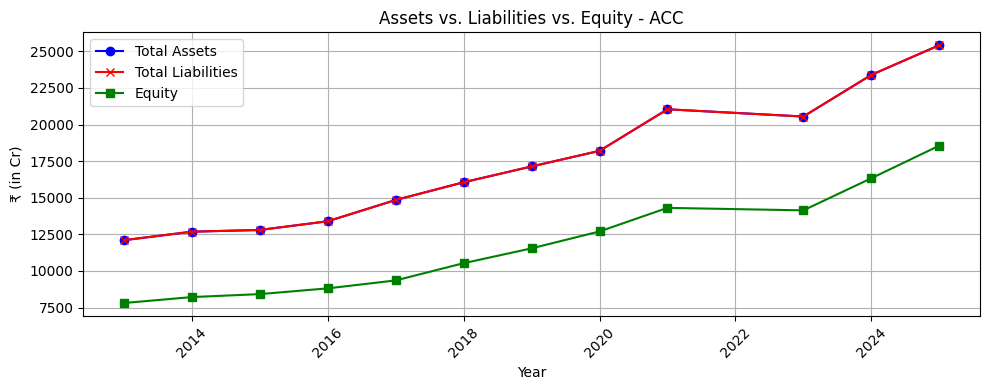

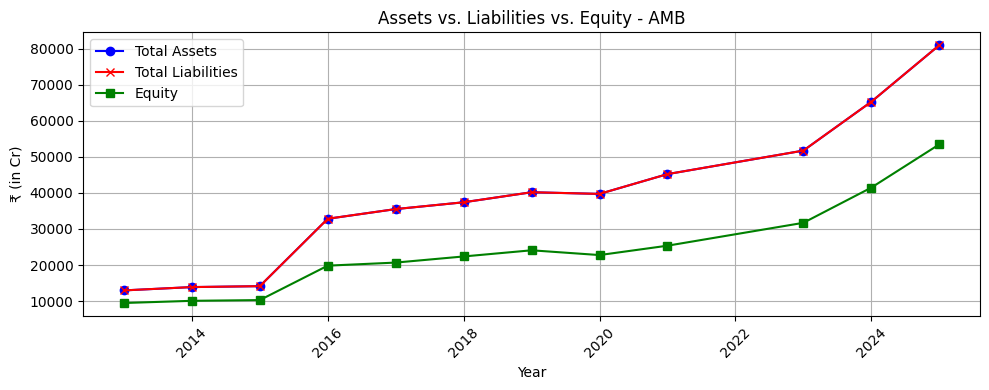

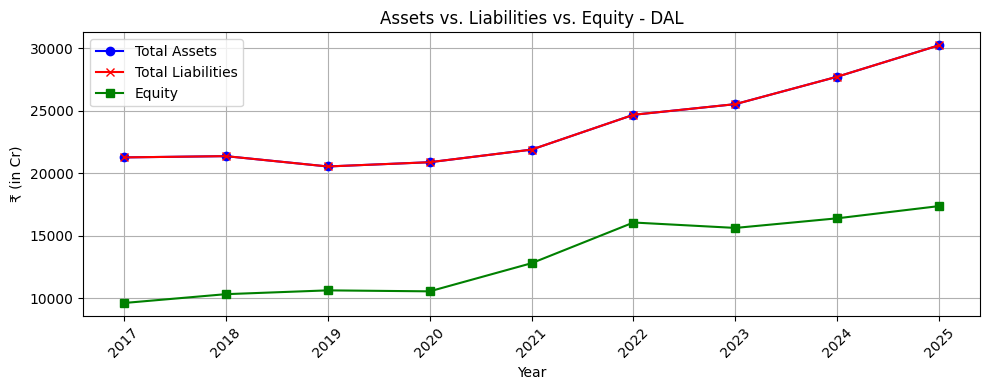

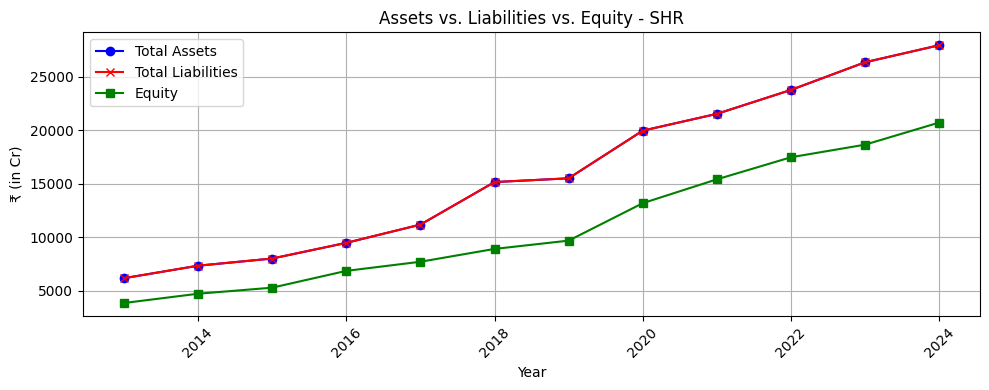

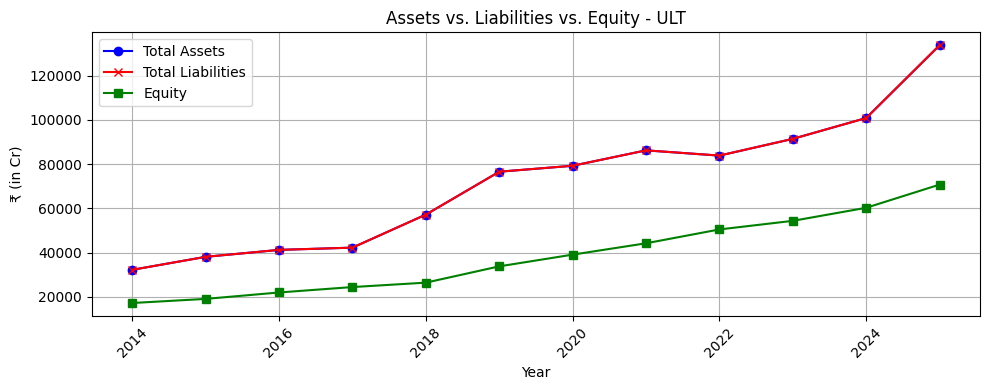

In [33]:
import matplotlib.pyplot as plt

def plot_assets_liabilities_equity(pivot_df, companies=None, title_prefix="Assets vs. Liabilities vs. Equity"):
    
    # Filter companies if list provided
    plot_df = pivot_df.copy()
    if companies:
        plot_df = plot_df[plot_df['Company_Code'].isin(companies)]

    for company in plot_df['Company_Code'].unique():
        company_data = plot_df[plot_df['Company_Code'] == company].sort_values('Year')

        if company_data.empty:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(company_data['Year'], company_data['Total Assets'], label='Total Assets', marker='o', color='blue')
        plt.plot(company_data['Year'], company_data['Total Liabilities'], label='Total Liabilities', marker='x', color='red')
        plt.plot(company_data['Year'], company_data['Equity'], label='Equity', marker='s', color='green')

        plt.title(f"{title_prefix} - {company}")
        plt.xlabel("Year")
        plt.ylabel("₹ (in Cr)")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Plot for all companies
plot_assets_liabilities_equity(equity_df)


Column chart for Debt-Equity Ratio per company per year.




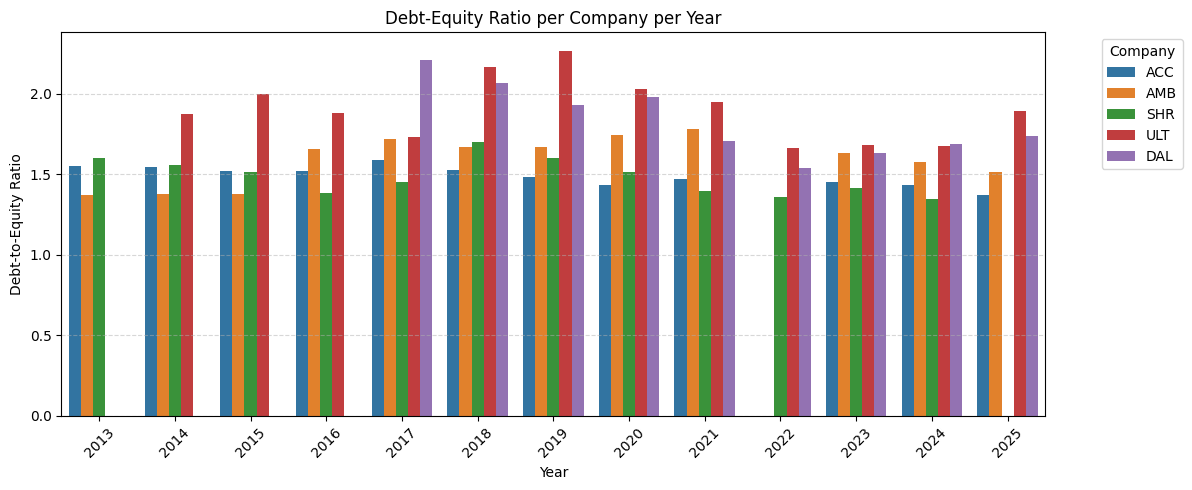

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_debt_equity_ratio(pivot_df, companies=None, title="Debt-Equity Ratio per Company per Year"):
    """
    Dynamically computes and plots the Debt-to-Equity ratio using Seaborn barplot.

    Parameters:
    - pivot_df: DataFrame with at least 'Company_Code', 'Year', 'Total Liabilities', 'Equity'
    - companies: Optional list of company codes to filter
    - title: Custom title for the plot
    """
    # Ensure numeric
    pivot_df['Total Liabilities'] = pd.to_numeric(pivot_df['Total Liabilities'], errors='coerce')
    pivot_df['Equity'] = pd.to_numeric(pivot_df['Equity'], errors='coerce')

    # Compute Debt-Equity Ratio
    pivot_df['Debt_Equity_Ratio'] = pivot_df['Total Liabilities'] / pivot_df['Equity']
    pivot_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

    # Drop missing
    de_df = pivot_df[['Company_Code', 'Year', 'Debt_Equity_Ratio']].dropna()

    # Filter if needed
    if companies:
        de_df = de_df[de_df['Company_Code'].isin(companies)]

    # Plot
    plt.figure(figsize=(12, 5))
    sns.barplot(data=de_df, x='Year', y='Debt_Equity_Ratio', hue='Company_Code', errorbar=None)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Debt-to-Equity Ratio")
    plt.xticks(rotation=45)
    plt.legend(title="Company", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    
plot_debt_equity_ratio(equity_df)